Dataset (100%) prepared successfully!
Found 3229 images belonging to 2 classes.
Found 924 images belonging to 2 classes.
Found 462 images belonging to 2 classes.


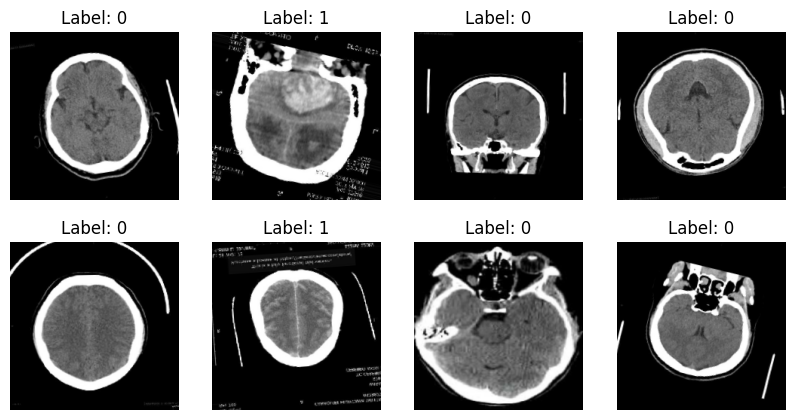

Image statistics:
Mean pixel value: 0.2397
Standard deviation: 0.3156
Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8007 - loss: 0.4719 - val_accuracy: 0.9156 - val_loss: 0.1784
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9262 - loss: 0.1934 - val_accuracy: 0.9199 - val_loss: 0.1723
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9391 - loss: 0.1558 - val_accuracy: 0.9578 - val_loss: 0.1045
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9461 - loss: 0.1351 - val_accuracy: 0.9632 - val_loss: 0.0962
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9473 - loss: 0.1251 - val_accuracy: 0.9307 - val_loss: 0.1724
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9560 - loss: 0.1050 - val_accuracy: 0.9524 - val_loss: 0.1092
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9613 - loss: 0.0892 - val_accuracy: 0.9545 - val_loss: 0.0913
Epoch 8/10
101/101 ━━━━━━━━

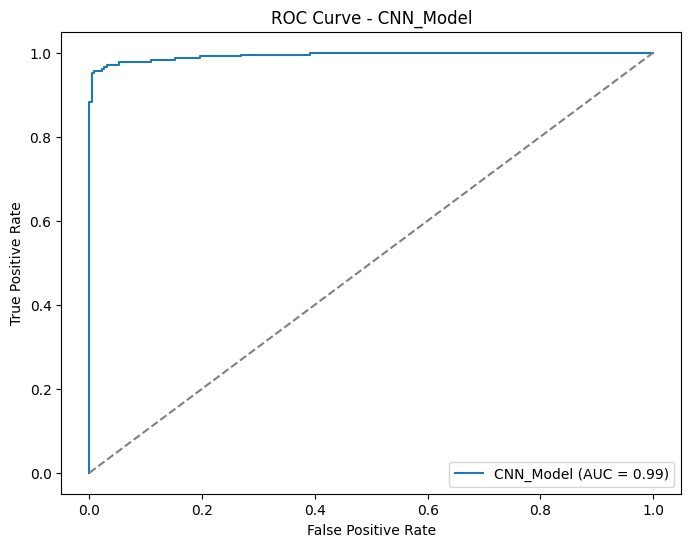

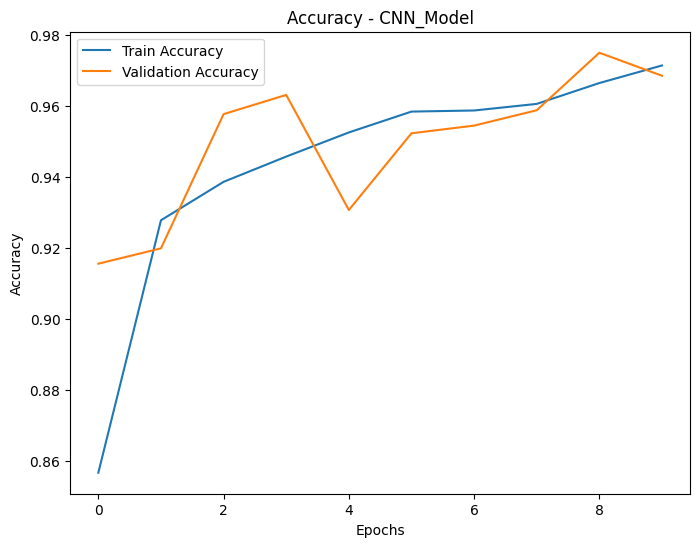

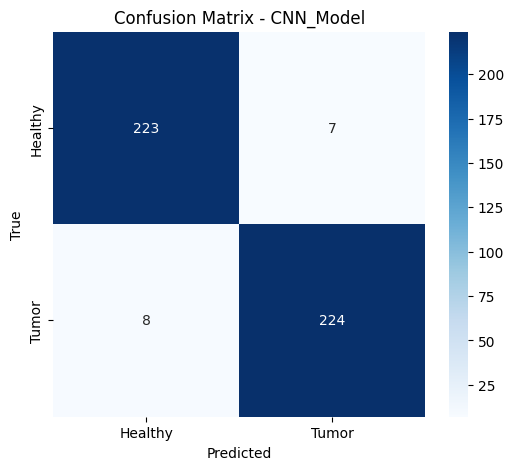

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 947s 9s/step - accuracy: 0.6977 - loss: 0.5704 - val_accuracy: 0.8918 - val_loss: 0.3187
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 939s 9s/step - accuracy: 0.8655 - loss: 0.3309 - val_accuracy: 0.8961 - val_loss: 0.2531
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 921s 9s/step - accuracy: 0.8894 - loss: 0.2696 - val_accuracy: 0.9167 - val_loss: 0.2373
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 928s 9s/step - accuracy: 0.9028 - loss: 0.2601 - val_accuracy: 0.9210 - val_loss: 0.1959
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 863s 9s/step - accuracy: 0.9138 - loss: 0.2324 - val_accuracy: 0.9340 - val_loss: 0.1813
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 919s 9s/step - accuracy: 0.9271 - loss: 0.2151 - val_accuracy: 0.9405 - val_loss: 0.1782
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 875s 9s/step - accuracy: 0.9273 - loss: 0.2051 - val_accuracy: 0.9481 - val_loss: 0.1734
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 840s 8s/step - accuracy: 0.9195 - loss: 0.2071 - val_accu

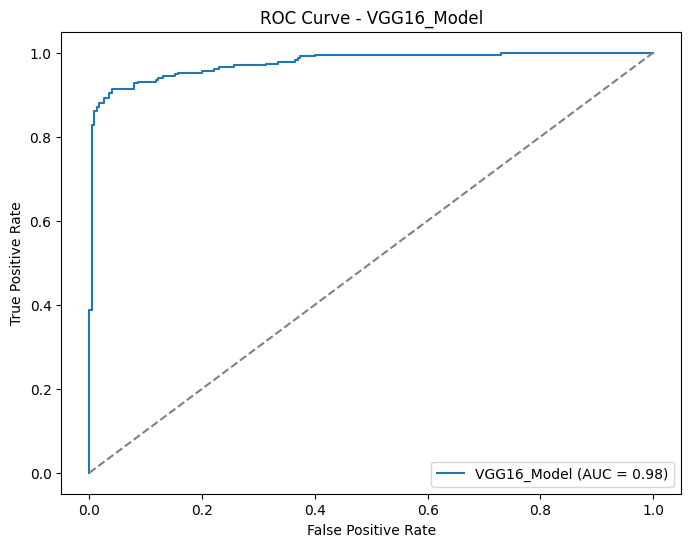

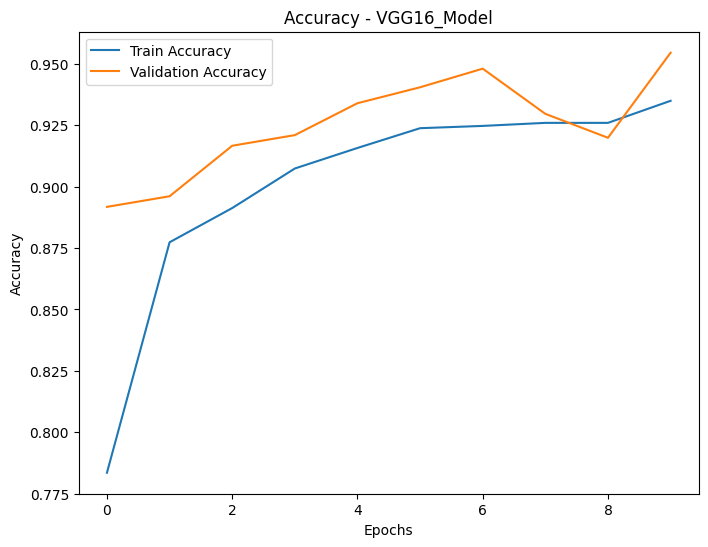

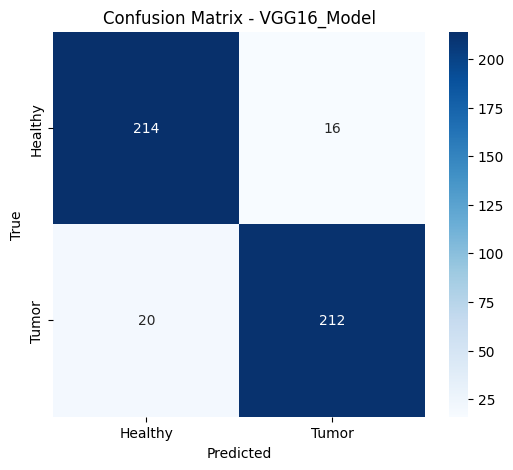

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.6033 - loss: 0.6916 - val_accuracy: 0.7846 - val_loss: 0.4989
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.7627 - loss: 0.5165 - val_accuracy: 0.8041 - val_loss: 0.4447
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.7535 - loss: 0.5208 - val_accuracy: 0.8149 - val_loss: 0.4185
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.7705 - loss: 0.4859 - val_accuracy: 0.8323 - val_loss: 0.3945
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.8102 - loss: 0.4341 - val_accuracy: 0.8268 - val_loss: 0.3885
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.7954 - loss: 0.4446 - val_accuracy: 0.8409 - val_loss: 0.3599
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.8094 - loss: 0.4280 - val_accuracy: 0.8312 - val_loss: 0.3896
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.8136 - loss: 0.4296 - val_accu

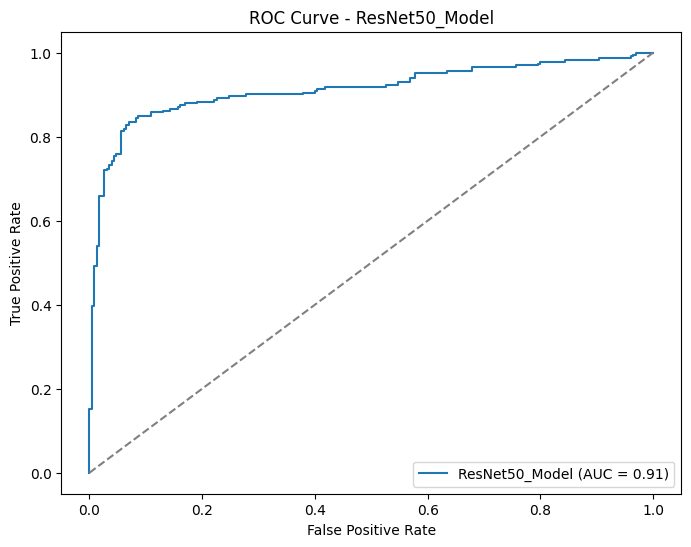

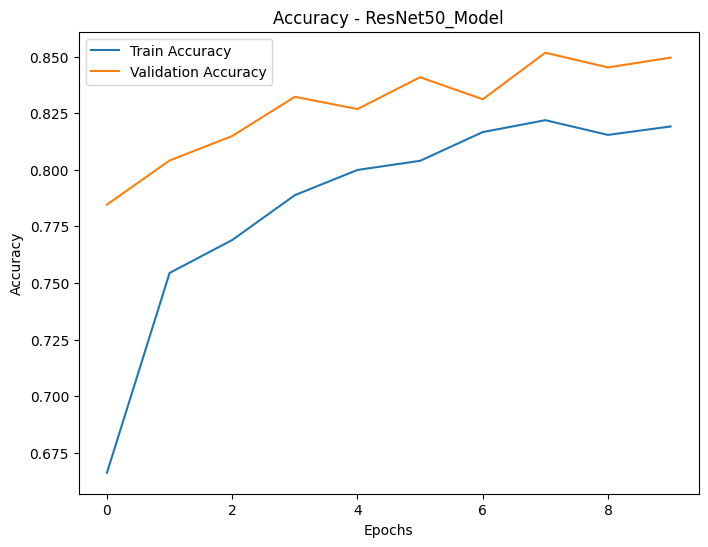

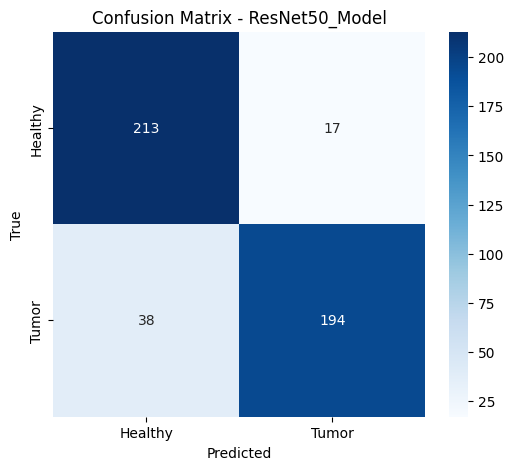

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 689s 6s/step - accuracy: 0.7869 - loss: 0.4344 - val_accuracy: 0.9134 - val_loss: 0.2163
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 803s 8s/step - accuracy: 0.9123 - loss: 0.2296 - val_accuracy: 0.9361 - val_loss: 0.1668
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.9309 - loss: 0.1834 - val_accuracy: 0.9394 - val_loss: 0.1561
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.9389 - loss: 0.1642 - val_accuracy: 0.9416 - val_loss: 0.1500
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.9444 - loss: 0.1502 - val_accuracy: 0.9416 - val_loss: 0.1490
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 475s 5s/step - accuracy: 0.9510 - loss: 0.1388 - val_accuracy: 0.9513 - val_loss: 0.1357
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.9574 - loss: 0.1258 - val_accuracy: 0.9502 - val_loss: 0.1373
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 368s 4s/step - accuracy: 0.9595 - loss: 0.1152 - val_accu

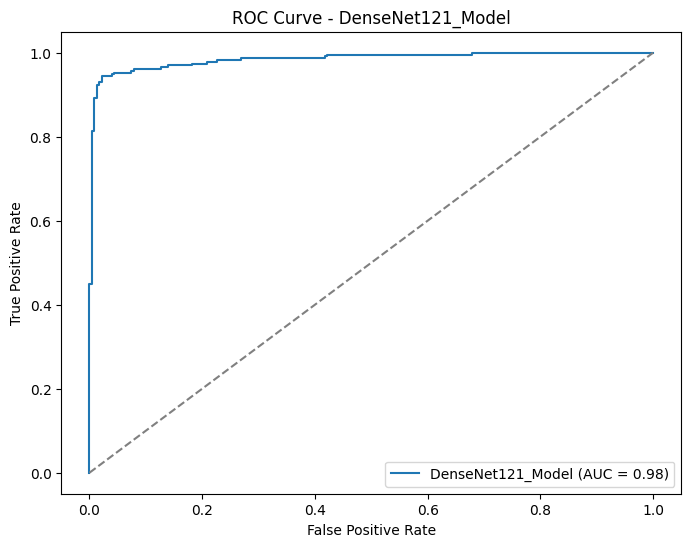

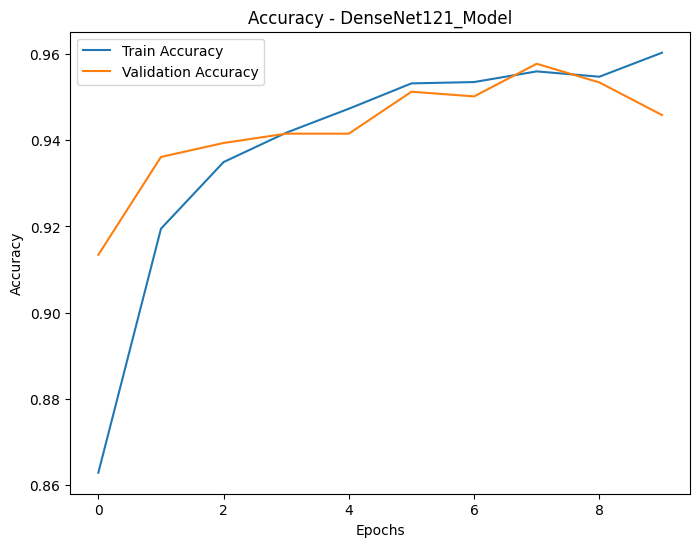

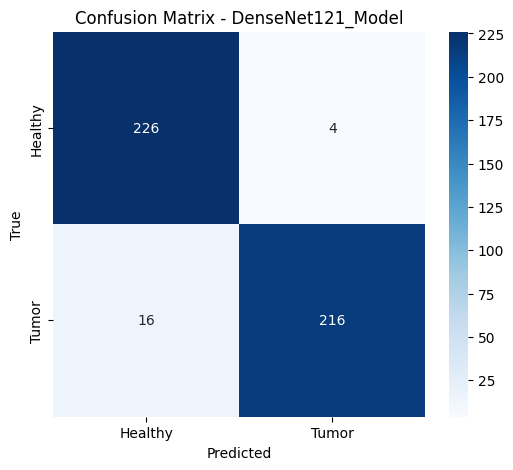

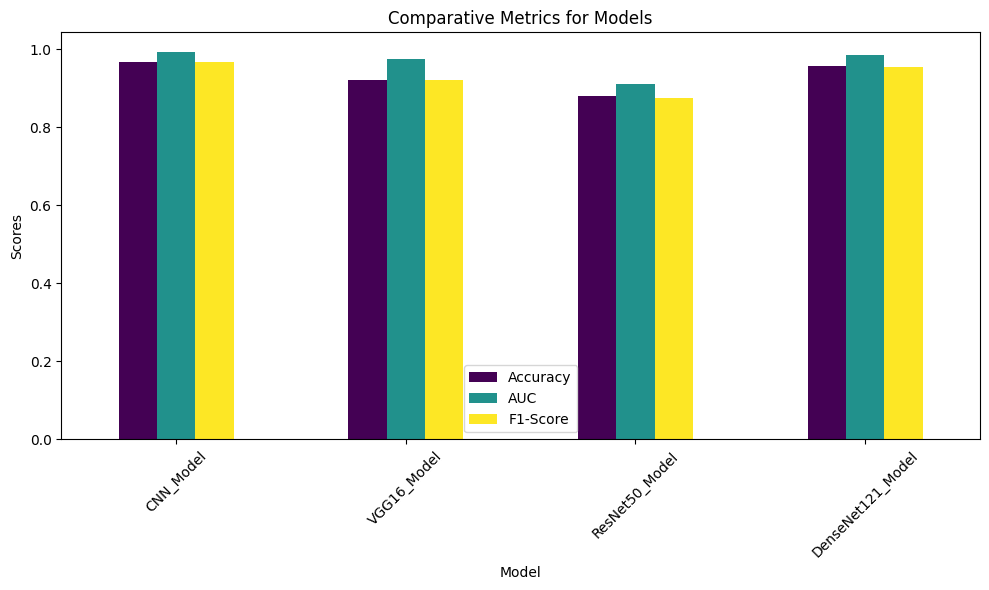

Best Model: CNN_Model


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil

# Paths and Parameters
dataset_path = "./CT/Brain Tumor CT scan Images"
train_dir = "./data01/train"
val_dir = "./data01/val"
test_dir = "./data01/test"
outcome_dir = "./outcome03"
image_size = (224, 224)
batch_size = 32
epochs = 10
random_seed = 42

# Ensure outcome directory exists
os.makedirs(outcome_dir, exist_ok=True)
os.makedirs(os.path.join(outcome_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(outcome_dir, "plots"), exist_ok=True)
os.makedirs(os.path.join(outcome_dir, "results"), exist_ok=True)


# Prepare Dataset with 10% Subset
def prepare_dataset_10_percent(dataset_path, train_dir, val_dir, test_dir, val_split=0.2, test_split=0.1):
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(val_dir):
        shutil.rmtree(val_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for label in ["Healthy", "Tumor"]:
        img_dir = os.path.join(dataset_path, label)
        images = os.listdir(img_dir)
        images = [os.path.join(img_dir, img) for img in images]

        # Select 10% of the data
        subset_images = np.random.choice(images, int(len(images) * 1), replace=False)

        train_images, temp_images = train_test_split(subset_images, test_size=(val_split + test_split), random_state=random_seed)
        val_images, test_images = train_test_split(temp_images, test_size=test_split / (val_split + test_split), random_state=random_seed)

        # Copy images to respective directories
        for img in train_images:
            dest = os.path.join(train_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

        for img in val_images:
            dest = os.path.join(val_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

        for img in test_images:
            dest = os.path.join(test_dir, label)
            os.makedirs(dest, exist_ok=True)
            shutil.copy(img, dest)

    print("Dataset (100%) prepared successfully!")
    
# Data Generators
def create_generators(train_dir, val_dir, test_dir, image_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, horizontal_flip=True, rotation_range=15)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir, target_size=image_size, batch_size=batch_size, class_mode="binary"
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
    )

    return train_generator, val_generator, test_generator


from tensorflow.keras.layers import Input
# Build CNN Model
def build_cnn_model(input_shape, dropout_rate=0.5):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(dropout_rate),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Build Pre-trained Models
def build_pretrained_model(base_model, input_shape, dropout_rate=0.5):
    base_model = base_model(include_top=False, weights="imagenet", input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Comparative metrics storage
metrics_summary = []

# Train and Evaluate Model
def train_and_evaluate_model(model, train_generator, val_generator, test_generator, model_name):
    checkpoint = ModelCheckpoint(os.path.join(outcome_dir, "models", f"{model_name}.keras"), monitor="val_accuracy", save_best_only=True, mode="max")
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Evaluate on Test Data
    test_loss, test_accuracy = model.evaluate(test_generator)

    # Predictions for AUC and Metrics
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

    # Save classification report
    report = classification_report(y_true, (y_pred > 0.5).astype(int), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(outcome_dir, "results", f"{model_name}_classification_report.csv"))

    # Add results to summary
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": test_accuracy,
        "AUC": roc_auc,
        "F1-Score": f1
    })

    # Save and Plot Metrics
    plot_metrics(model_name, history, fpr, tpr, roc_auc, y_true, y_pred)

    return test_accuracy

def plot_metrics(model_name, history, fpr, tpr, roc_auc, y_true, y_pred):
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(outcome_dir, "plots", f"{model_name}_ROC.png"))
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(outcome_dir, "plots", f"{model_name}_Accuracy.png"))
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Tumor"], yticklabels=["Healthy", "Tumor"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(os.path.join(outcome_dir, "plots", f"{model_name}_Confusion_Matrix.png"))
    plt.show()

# Compare Models and Save Best
def compare_and_save_best():
    metrics_df = pd.DataFrame(metrics_summary)
    metrics_df.to_csv(os.path.join(outcome_dir, "results", "metrics_summary.csv"), index=False)

    # Plot Comparative Metrics
    metrics_df.set_index("Model", inplace=True)
    metrics_df[["Accuracy", "AUC", "F1-Score"]].plot(kind="bar", figsize=(10, 6), colormap="viridis")
    plt.title("Comparative Metrics for Models")
    plt.ylabel("Scores")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(outcome_dir, "plots", "Comparative_Metrics.png"))
    plt.show()

    # Select Best Model
    best_model_row = metrics_df[metrics_df["Accuracy"] == metrics_df["Accuracy"].max()]
    best_model_name = best_model_row.index[0]
    print(f"Best Model: {best_model_name}")
    return best_model_name

# Visualize Images and Statistics
def visualize_data(generator):
    sample_images, sample_labels = next(generator)
    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"Label: {int(sample_labels[i])}")
        plt.axis("off")
    plt.savefig(os.path.join(outcome_dir, "plots", "Sample_Images.png"))
    plt.show()
    plt.close()

    print("Image statistics:")
    print(f"Mean pixel value: {np.mean(sample_images):.4f}")
    print(f"Standard deviation: {np.std(sample_images):.4f}")

# Main Execution
if __name__ == "__main__":
    prepare_dataset_10_percent(dataset_path, train_dir, val_dir, test_dir)
    train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir, image_size, batch_size)

    input_shape = image_size + (3,)

    # Visualize Images and Statistics
    visualize_data(train_gen)    

    # Build and Train Models
    cnn_model = build_cnn_model(input_shape)
    cnn_accuracy = train_and_evaluate_model(cnn_model, train_gen, val_gen, test_gen, "CNN_Model")

    vgg16_model = build_pretrained_model(VGG16, input_shape)
    vgg16_accuracy = train_and_evaluate_model(vgg16_model, train_gen, val_gen, test_gen, "VGG16_Model")

    resnet_model = build_pretrained_model(ResNet50, input_shape)
    resnet_accuracy = train_and_evaluate_model(resnet_model, train_gen, val_gen, test_gen, "ResNet50_Model")

    densenet_model = build_pretrained_model(DenseNet121, input_shape)
    densenet_accuracy = train_and_evaluate_model(densenet_model, train_gen, val_gen, test_gen, "DenseNet121_Model")

    # Compare Models and Save Best
    best_model_name = compare_and_save_best()
